In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import requests
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import pickle
import os


In [2]:
# read data_processed.csv
# data_path = '/content/drive/MyDrive/BT5153/Data/'
df = pd.read_csv('Data_processed_reduced_v4.csv',encoding= 'unicode_escape')
df.shape

(18680, 11)

In [5]:
# add img paths
df['img_path'] = df.img_id.apply(lambda x: '/content/drive/MyDrive/BT5153/Data/Pict/' + str(x) + '.jpg')

In [3]:
# padding 'ss' and 'ee' to the string to mark the begining and end
df['Description'] = df['Description'].apply(lambda x: 'ss '+ x + ' ee' )
df['Description'] = df['Description'].apply(lambda x: x.lower())

In [6]:
df['text_length'] = df['Description'].apply(lambda x: len(x.split()))
print(df['text_length'].mean())
np.quantile(df['text_length'],0.9)

33.003693790149896


62.0

In [5]:
#  build vocabulary using glove and vectorize the text
temp = []
for des in df.Description.values:
  temp.extend(des.split())
temp.append('@')

vocabulary = list(set(temp))
max_tokens = len(vocabulary)

print ("max token length : {}".format(max_tokens))
output_sequence_length=62
vectorizer = TextVectorization(max_tokens=max_tokens + 1, output_sequence_length=output_sequence_length, standardize=None)
# text_ds = df.Description.values
vectorizer.adapt(temp) 
voc = vectorizer.get_vocabulary()
print ("voc length : {}".format(len(voc)))
# del voc[1]
word_index = dict(zip(voc, range(len(voc))))
index_word = dict(zip(range(len(voc)), voc))
embeddings_index = {}
with open("glove.6B.50d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))
num_tokens = len(voc) 
embedding_dim = 50
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))
print ("Embeding matrix shape : {}".format(embedding_matrix.shape))

max token length : 8922
voc length : 8923
Found 400000 word vectors.
Converted 8364 words (559 misses)
Embeding matrix shape : (8923, 50)


In [68]:
with open('word_index.pkl','wb') as f:
    pickle.dump(word_index,f)
with open('index_word.pkl','wb') as f:
    pickle.dump(index_word,f)

In [6]:
# load image and preprocess to the format compatible to inception_v3
import cv2
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    
    return img

In [7]:
# define InceptionV3 image feature extraction model 
image_model = tf.keras.applications.InceptionV3(include_top=True,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [67]:
image_features_extract_model.save('image_features_extract_model')

INFO:tensorflow:Assets written to: image_features_extract_model/assets


INFO:tensorflow:Assets written to: image_features_extract_model/assets


In [10]:
import numpy as np

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])


  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


In [11]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)
def scaled_dot_product_attention(q, k, v, mask):
  

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

 
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  


  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights 

In [12]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x,batch_size):
    """分拆最后一个维度到 (num_heads, depth).
    转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [13]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])


In [14]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)



  def call(self, x, enc_output, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [15]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model,embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), trainable=False)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output,  
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, 
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [16]:
class Transformer(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, max_len,num_heads, dff,  
               target_vocab_size,  pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = tf.keras.layers.Dense(d_model*max_len)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size,activation='softmax')
    self.max_len = max_len
    self.d_model = d_model

  def call(self, inp, tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    # combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    enc_output = self.encoder(inp)  # (batch_size, inp_seq_len, d_model)
    enc_output = tf.reshape(enc_output,(-1,self.max_len,self.d_model))
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, look_ahead_mask,  dec_target_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)


    return final_output

In [22]:
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
num_layers = 6
dff=512
d_model=50
num_heads = 5
dropout_rate = 0.1
target_vocab_size = len(voc)
maximum_position_encoding=61
max_len=61
input1 = tf.keras.layers.Input(shape=(1,2048))
input2 = tf.keras.layers.Input(shape=(None,))
transformer = Transformer(num_layers, d_model,max_len, num_heads, dff, target_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

outputs = transformer(input1, input2)

caption_model = Model(inputs=[input1, input2], outputs=outputs)
# Checkpoint
# checkpoint_filepath = '/content/drive/MyDrive/checkpoint_models_hj/checkpoint5.ckpt'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_loss',
#     mode='min',
#     save_best_only=True)
# class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#   def __init__(self, d_model, warmup_steps=4000):
#     super(CustomSchedule, self).__init__()

#     self.d_model = d_model
#     self.d_model = tf.cast(self.d_model, tf.float32)

#     self.warmup_steps = warmup_steps

#   def __call__(self, step):
#     arg1 = tf.math.rsqrt(step)
#     arg2 = step * (self.warmup_steps ** -1.5)

#     return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(0.01, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Early Stopping
# earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1, restore_best_weights=True, mode='min')

caption_model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=['accuracy'])

caption_model.summary()
# plot_model(caption_model, to_file='model.png', show_shapes=True, show_layer_names=True)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1, 2048)]    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
transformer_1 (Transformer)     (None, None, 8923)   7585445     input_4[0][0]                    
                                                                 input_5[0][0]                    
Total params: 7,585,445
Trainable params: 7,139,295
Non-trainable params: 446,150
__________________________________________________________________________________________________


In [18]:
class Generator(tf.keras.utils.Sequence) :
  
  def __init__(self, df, batch_size) :
    self.paths = df.img_path.values
    self.descriptions = df.description.values
    self.batch_size = batch_size  
    # self.on_epoch_end()
    
  def __len__(self) :
    return (np.ceil(len(self.paths) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    images = np.array([load_image(path) for path in self.paths[idx * self.batch_size : (idx+1) * self.batch_size]])
    image_features = image_features_extract_model(images)
    image_features = tf.reshape(image_features,
                              (image_features.shape[0], -1,image_features.shape[1]))
   
    texts = np.array(self.descriptions[idx * self.batch_size : (idx+1) * self.batch_size])
    texts = vectorizer(texts)
    x2 = texts[:,:-1]
    y = texts[:,1:]
    return [image_features,x2], y 

# df_train = df.sample(frac=0.8, random_state=123)
# df_validation = df.loc[~df.index.isin(df_train.index)]
# df_train = df_train.reset_index()
# df_validation = df_validation.reset_index()
# print ("train size : ", df_train.shape[0])
# print ("validation size : ", df_validation.shape[0])
# BATCH_SIZE = 20
# train_generator = Generator(df_train, BATCH_SIZE)
# validation_generator = Generator(df_validation, BATCH_SIZE)

In [56]:
# load_image(df.img_path[0])

**Model Training**

In [ ]:
# Model Training (1st epoch)
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=2, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

In [23]:
my_filepath = 'checkpoint/checkpoint5.ckpt'
# caption_model.save_weights(my_filepath)
caption_model.load_weights(my_filepath)

In [24]:
caption_model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [67]:
caption_model.fit(train_generator, 
                  validation_data=validation_generator, 
                  epochs=8, 
                  verbose=1, 
                  callbacks=[earlystopping, model_checkpoint_callback])

Epoch 1/8
748/748 [==============================] - 511s 665ms/step - loss: 2.2670 - accuracy: 0.6146 - val_loss: 2.0004 - val_accuracy: 0.6533
Epoch 2/8
748/748 [==============================] - 498s 666ms/step - loss: 1.9950 - accuracy: 0.6481 - val_loss: 1.7972 - val_accuracy: 0.6822
Epoch 3/8
748/748 [==============================] - 494s 660ms/step - loss: 1.7825 - accuracy: 0.6800 - val_loss: 1.6654 - val_accuracy: 0.7033
Epoch 4/8
748/748 [==============================] - 492s 658ms/step - loss: 1.6665 - accuracy: 0.6968 - val_loss: 1.5517 - val_accuracy: 0.7199
Epoch 5/8
748/748 [==============================] - 496s 663ms/step - loss: 1.5516 - accuracy: 0.7141 - val_loss: 1.5013 - val_accuracy: 0.7279
Epoch 6/8
748/748 [==============================] - 496s 663ms/step - loss: 1.4789 - accuracy: 0.7242 - val_loss: 1.4448 - val_accuracy: 0.7371
Epoch 7/8
748/748 [==============================] - 503s 672ms/step - loss: 1.4245 - accuracy: 0.7323 - val_loss: 1.4219 - val_ac

**Generate captions from trained model**

In [25]:
def generateCaption(img_path):
  photo = load_image(img_path)
  photo = tf.reshape(photo,(1,photo.shape[0],photo.shape[1],photo.shape[2]))
  photo = image_features_extract_model(photo)
  photo = tf.reshape(photo,(-1,1,2048))
  # print ("photo {}".format(photo.shape))
  in_text = 'ss'
  for i in range(61):
      # print ('in text : {}'.format(in_text))
      sequence = np.array([word_index[w] for w in in_text.split() if w in word_index])
      sequence = pad_sequences([sequence],maxlen = max_len,padding='post',truncating='post')
      yhat = caption_model.predict([photo,sequence], verbose=0)
      yhat = np.argmax(yhat.reshape(-1,max_tokens+1),axis=1)
      output = yhat[i]
      if index_word[output] == 'ee':
        break
      # print ("output : {}".format(output))
      in_text  +=  ' ' + index_word[output]

  return "" if in_text == 'ss' else in_text[3:]

In [27]:
caption_model = tf.keras.models.load_model(
    'model', custom_objects=None, compile=True
)


pockets and zip pockets give this zip through sweatshirt a modern look                                                 


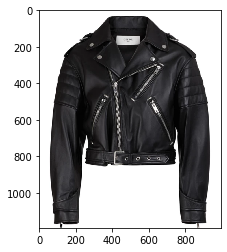

In [66]:
import matplotlib.pyplot as plt
path  = '1.jpg'
final = generateCaption(path)
img = plt.imread(path)
print(final)
plt.imshow(img)


In [29]:
# pandarallel.initialize(progress_bar  = True)
from tqdm import tqdm
tqdm.pandas()
df_validation['pred_cap'] = df_validation['img_path'].progress_apply(generateCaption)

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 3736/3736 [4:30:21<00:00,  4.34s/it]


In [30]:
df_validation.to_csv( '/content/drive/MyDrive/df_validation.csv')

In [32]:
len(df_validation.pred_cap.unique())

2387

In [41]:
df_validation.pred_cap.apply(lambda x: len(x.split())).describe()

count    3736.000000
mean        9.131424
std         3.616061
min         0.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        61.000000
Name: pred_cap, dtype: float64

In [62]:
for i in df_validation.pred_cap[:20]:
  print(i)

a classic design for easy colours                                                       
and comfortable cotton shorts featuring a unique block design                                                    
and sporty design the it sportswear construction gives this polo brand a modern look                                               
dress with a bold tie dye finish                                                      
shorts with a detachable tie belt at the waist and a slit                                                 
and sporty design the it sportswear jacket is perfect for everyday wear                                                 
and sporty design for easy colours                                                       
neck jumper in soft cotton jersey with a high waist                                                   
and sporty design make this polo dress a stylish look                                                   
neck jumper in soft jersey with a high waist and wid

In [33]:
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu

In [51]:
def bleu_score(df):
  bleu1=[]
  bleu2 =[]
  bleu3 = []
  bleu4=[]
  real_cap=df.Description.apply(lambda x: x.split()[:32] if len(x.split())>32 else x.split() )
  # real_cap = df.Description
  pred_cap=df.pred_cap
  for i in range(len(df)):
    bleu1.append(sentence_bleu([real_cap[i]],pred_cap[i].split(),weights=(1,0,0,0),smoothing_function=SmoothingFunction().method1))
    bleu2.append(sentence_bleu([real_cap[i]],pred_cap[i].split(),weights=(0.5,0.5,0,0),smoothing_function=SmoothingFunction().method1))
    bleu3.append(sentence_bleu([real_cap[i]],pred_cap[i].split(),weights=(0.3,0.3,0.3,0),smoothing_function=SmoothingFunction().method1))
    bleu4.append(sentence_bleu([real_cap[i]],pred_cap[i].split(),weights=(0.25,0.25,0.25,0.25),smoothing_function=SmoothingFunction().method1))
  df['bleu1']= bleu1
  df['bleu2']= bleu2
  df['bleu3']= bleu3
  df['bleu4']= bleu4
  return df

  

In [52]:
df_validation = bleu_score(df_validation)

bleu1 mean is 0.06908498988935895


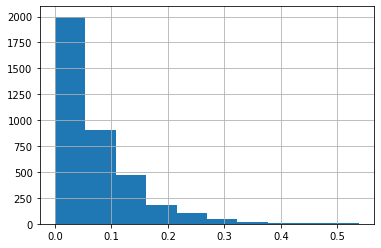

In [57]:
print('bleu1 mean is {}'.format(df_validation.bleu1.mean()))
df_validation.bleu1.hist()

bleu2 mean is 0.027501228883174824


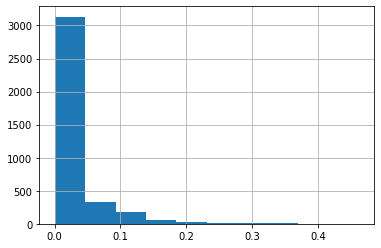

In [58]:
print('bleu2 mean is {}'.format(df_validation.bleu2.mean()))
df_validation.bleu2.hist()

bleu3 mean is 0.018930506330937184


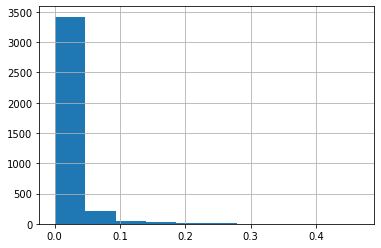

In [59]:
print('bleu3 mean is {}'.format(df_validation.bleu3.mean()))
df_validation.bleu3.hist()

bleu4 mean is 0.010345151687094394


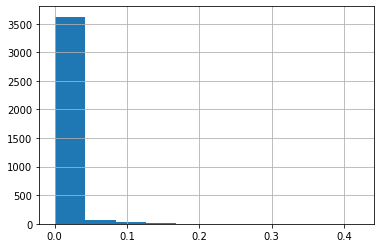

In [60]:
print('bleu4 mean is {}'.format(df_validation.bleu4.mean()))
df_validation.bleu4.hist()